Data Source : https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


In [338]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from datetime import datetime
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

Import Data

In [339]:
market_df = pd.read_csv('../data/marketing_campaign.csv')
market_df.shape

(2240, 29)

Explore data

In [340]:
market_df.head(2)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0


In [341]:
# Change birth year to age, customer date to years

def years_customer(inp_date):
    format_Dt = pd.to_datetime(inp_date, format="%d-%m-%Y")
    today = datetime.today()
    return today.year - format_Dt.year - ((today.month, today.day) < (format_Dt.month, format_Dt.day))

market_df['Yrs_Customer'] = market_df['Dt_Customer'].apply(lambda x: years_customer(x))

market_df['age'] = 2022 - market_df['Year_Birth']

#market_df.head(2)


In [342]:
# drop age outliers
#market_df.drop(market_df[ (market_df['age'] >= 80) & (market_df['age'] <= 0)].index, inplace = True)

# drop non-needed cols
market_df.drop(columns=['Z_CostContact','Z_Revenue','Dt_Customer','Year_Birth'], inplace=True)

# market_df.head(2)

In [343]:
# Trying to standardize these cols individually with Standard Scalar causes divide by 0 exceptions, bcz some values are 0. So getting a total of all spending here.

market_df['Total_Spent'] = market_df['MntWines'] + market_df['MntFruits'] +market_df['MntMeatProducts'] +market_df['MntFishProducts'] +market_df['MntSweetProducts'] + market_df['MntGoldProds']

In [344]:
print('\n',market_df[['Total_Spent']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['Total_Spent']].value_counts())


         Total_Spent
mean     605.798214
median   396.000000
min        5.000000
max     2525.000000
std      602.249288

 Total_Spent
46             19
22             18
57             16
44             15
55             15
               ..
347             1
999             1
1003            1
341             1
5               1
Length: 1054, dtype: int64


In [345]:
market_df.drop(columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], inplace=True)

In [346]:
print('\n',market_df[['NumDealsPurchases']].value_counts())
print('\n',market_df[['NumWebPurchases']].value_counts())
print('\n',market_df[['NumCatalogPurchases']].value_counts())
print('\n',market_df[['NumStorePurchases']].value_counts())
print('\n',market_df[['NumWebVisitsMonth']].value_counts())



 NumDealsPurchases
1                    970
2                    497
3                    297
4                    189
5                     94
6                     61
0                     46
7                     40
8                     14
9                      8
15                     7
10                     5
11                     5
12                     4
13                     3
dtype: int64

 NumWebPurchases
2                  373
1                  354
3                  336
4                  280
5                  220
6                  205
7                  155
8                  102
9                   75
0                   49
11                  44
10                  43
27                   2
23                   1
25                   1
dtype: int64

 NumCatalogPurchases
0                      586
1                      497
2                      276
3                      184
4                      182
5                      140
6                      128
7    

In [347]:

print('\n',market_df[['NumDealsPurchases']].agg(['mean','median','min','max', 'std']))


         NumDealsPurchases
mean             2.325000
median           2.000000
min              0.000000
max             15.000000
std              1.932238


In [348]:
# Cannot standardize these cols again bcz 0 values cause divide by 0 error in Standard Scalar - summing them into an aggregate and then standardizing
# what happens if I drop th

In [349]:
# target Variable : Response - Results are not exactly 50-50 but we still proceed.
print(market_df[['Response']].value_counts())

Response
0           1906
1            334
dtype: int64


In [350]:
# Continuous Vars
print('\n',market_df[['Income']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['age']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['Yrs_Customer']].agg(['mean','median','min','max', 'std']))



                Income
mean     52247.251354
median   51381.500000
min       1730.000000
max     666666.000000
std      25173.076661

                age
mean     53.194196
median   52.000000
min      26.000000
max     129.000000
std      11.984069

         Yrs_Customer
mean        8.345089
median      8.000000
min         7.000000
max         9.000000
std         0.603046


In [351]:
# categorical variables
print('\n',market_df[['Education']].value_counts())
print('\n',market_df[['Marital_Status']].value_counts())


 Education 
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
dtype: int64

 Marital_Status
Married           864
Together          580
Single            480
Divorced          232
Widow              77
Alone               3
Absurd              2
YOLO                2
dtype: int64


In [352]:
market_df.replace("2n Cycle", "Unknown", inplace=True)
market_df.replace("Alone", "Single", inplace=True)
market_df.replace("Absurd", "Unknown", inplace=True)
market_df.replace("YOLO", "Unknown", inplace=True)

print('\n',market_df[['Education']].value_counts())
print('\n',market_df[['Marital_Status']].value_counts())


 Education 
Graduation    1127
PhD            486
Master         370
Unknown        203
Basic           54
dtype: int64

 Marital_Status
Married           864
Together          580
Single            483
Divorced          232
Widow              77
Unknown             4
dtype: int64


In [353]:
### Data Cleaning
# drop all Nulls
market_df.isnull().sum()



ID                      0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Recency                 0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
Yrs_Customer            0
age                     0
Total_Spent             0
dtype: int64

In [354]:
market_df.dropna(inplace=True)
market_df.reset_index(drop=True, inplace=True)
market_df.head(2).T

,0,1
ID,5524,2174
Education,Graduation,Graduation
Marital_Status,Single,Single
Income,58138.0,46344.0
Kidhome,0,1
Teenhome,0,1
Recency,58,38
NumDealsPurchases,3,2
NumWebPurchases,8,1
NumCatalogPurchases,10,1


Visualize figure

## Categorical variables
- One hot encoding: Marital_Status & Education
- Standardize other values

In [355]:
encoder1=OneHotEncoder()
ohe1=pd.DataFrame(encoder1.fit_transform(market_df[['Education']]).toarray())
col_list1 = ['Education_{}'.format(item) for item in market_df['Education'].value_counts().index]
ohe1.columns=col_list1
market_df = pd.concat([market_df, ohe1],axis=1)

In [356]:
encoder2=OneHotEncoder()
ohe2=pd.DataFrame(encoder2.fit_transform(market_df[['Marital_Status']]).toarray())
col_list2 = ['Marital_Status_{}'.format(item) for item in market_df['Marital_Status'].value_counts().index]
ohe2.columns=col_list2
market_df = pd.concat([market_df, ohe2],axis=1)

In [357]:
market_df.head(2).T

,0,1
ID,5524,2174
Education,Graduation,Graduation
Marital_Status,Single,Single
Income,58138.0,46344.0
Kidhome,0,1
Teenhome,0,1
Recency,58,38
NumDealsPurchases,3,2
NumWebPurchases,8,1
NumCatalogPurchases,10,1


In [426]:
test_df = market_df

In [427]:
ss_scaler0 = StandardScaler()
test_df['ln_age'] = ss_scaler0.fit_transform(np.array(test_df['age']).reshape(-1, 1))

ss_scaler1 = StandardScaler()
test_df['ln_Income'] = ss_scaler1.fit_transform(np.array(test_df['Income']).reshape(-1, 1)) 



In [428]:


#test_df = market_df.reset_index()
#test_df.loc[test_df["Recency"] == 0, "Recency"] = 999
#arr=np.log(test_df['Recency'])
#arr
ss_scaler2 = StandardScaler()
test_df['ln_Recency'] = ss_scaler2.fit_transform(np.array(test_df['Recency']).reshape(-1, 1))

ss_scaler3 = StandardScaler()
test_df['ln_Spending'] = ss_scaler3.fit_transform(np.array(test_df['Total_Spent']).reshape(-1, 1))

ss_scaler30 = MinMaxScaler()
test_df['ln_Yrs_Customer'] = ss_scaler30.fit_transform(np.array(test_df['Yrs_Customer']).reshape(-1, 1))

In [429]:

ss_scaler4 = MinMaxScaler()
test_df['ln_deals'] = ss_scaler4.fit_transform(np.array(test_df['NumDealsPurchases']).reshape(-1, 1))

ss_scaler40 = MinMaxScaler()
test_df['ln_web'] = ss_scaler40.fit_transform(np.array(test_df['NumWebPurchases']).reshape(-1, 1))

ss_scaler41 = MinMaxScaler()
test_df['ln_catalog'] = ss_scaler41.fit_transform(np.array(test_df['NumCatalogPurchases']).reshape(-1, 1))

ss_scaler42 = MinMaxScaler()
test_df['ln_store'] = ss_scaler42.fit_transform(np.array(test_df['NumStorePurchases']).reshape(-1, 1))

ss_scaler43 = MinMaxScaler()
test_df['ln_visits'] = ss_scaler43.fit_transform(np.array(test_df['NumWebVisitsMonth']).reshape(-1, 1))


In [430]:
test_df = test_df.dropna()

,0,1,2,3,4,5,6,7,8,9,10,11
ID,5524,2174,4141,6182,5324,7446,965,6177,4855,5899,387,2125
Education,Graduation,Graduation,Graduation,Graduation,PhD,Master,Graduation,PhD,PhD,PhD,Basic,Graduation
Marital_Status,Single,Single,Together,Together,Married,Together,Divorced,Married,Together,Together,Married,Divorced
Income,58138.0,46344.0,71613.0,26646.0,58293.0,62513.0,55635.0,33454.0,30351.0,5648.0,7500.0,63033.0
Kidhome,0,1,0,1,1,0,0,1,1,1,0,0
Teenhome,0,1,0,0,0,1,1,0,0,1,0,0
Recency,58,38,26,26,94,16,34,32,19,68,59,82
NumDealsPurchases,3,2,1,2,5,2,4,2,1,1,1,1
NumWebPurchases,8,1,8,2,5,6,7,4,3,1,2,3
NumCatalogPurchases,10,1,2,0,3,4,3,0,0,0,0,4


In [432]:
dropit=['Education', 'Marital_Status', 'Income', 'Recency', 'NumDealsPurchases', 'age', 'Total_Spent',
        'NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth', 'ID', 'Complain', 'Yrs_Customer']
test_df.drop(columns=dropit, inplace=True)

In [434]:
test_df.head(12).T

,0,1,2,3,4,5,6,7,8,9,10,11
Kidhome,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
Teenhome,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
AcceptedCmp3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
AcceptedCmp4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AcceptedCmp5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AcceptedCmp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AcceptedCmp2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Response,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
Education_Graduation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Education_PhD,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Model Evaluation

In [435]:
def mod_eval(df,predictions, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df['Response'][y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df['Response'][y_test.index], predictions))

In [436]:
# train-test split
X=test_df.drop(columns=['Response'])
y=test_df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size=.3,
                                                     stratify=test_df['Response'])

RandomForest

In [437]:
# grid search for optimal hyperparameters
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13],
               'n_estimators':[50,100,150]
              }

In [438]:
# grid search for optimal hyperparameters
model = RandomForestClassifier(random_state=42, 
                               n_jobs=4)
rf = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
rf.fit(X_train,y_train)
print(rf.best_params_)
print(rf.best_score_)

{'max_depth': 13, 'max_features': 7, 'n_estimators': 150}
0.8916938076962971


              precision    recall  f1-score   support

           0       0.87      0.92      0.89       580
           1       0.11      0.07      0.09        85

    accuracy                           0.81       665
   macro avg       0.49      0.49      0.49       665
weighted avg       0.77      0.81      0.79       665



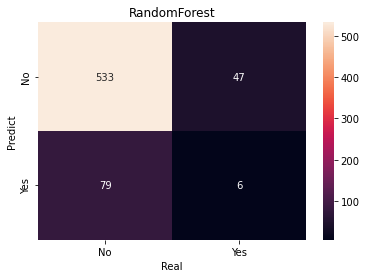

In [439]:
# evaluate the model
predprob = rf.predict_proba(X_test)
mod_eval(loans_df, rf.predict(X_test),  y_test, 'RandomForest')

Logistic Regression

In [440]:
# grid search for optimal hyperparameters
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
               'solver':['liblinear'] # this is the only solver that allow parameters
              }

In [441]:
# grid search for optimal hyperparameters
model = LogisticRegression(max_iter=1000)
lr = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
lr.fit(X_train,y_train)
print(lr.best_params_)
print(lr.best_score_)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.8923306710922103


              precision    recall  f1-score   support

           0       0.87      0.90      0.89       580
           1       0.12      0.09      0.11        85

    accuracy                           0.80       665
   macro avg       0.50      0.50      0.50       665
weighted avg       0.78      0.80      0.79       665



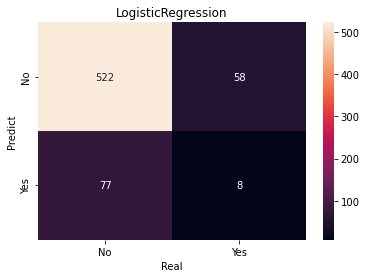

In [442]:
# evaluate the model
predprob = lr.predict_proba(X_test)
mod_eval(loans_df, lr.predict(X_test), y_test, 'LogisticRegression') 

NaiveBayes

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       580
           1       0.15      0.19      0.17        85

    accuracy                           0.76       665
   macro avg       0.52      0.52      0.52       665
weighted avg       0.78      0.76      0.77       665



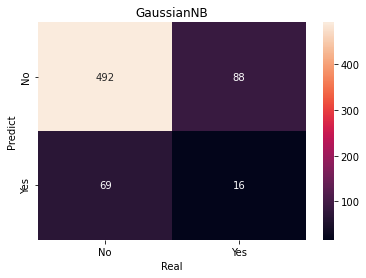

In [443]:
# there are no hyperparameters to gridsearch
gnb = GaussianNB()
gnb.fit(X_train, y_train)
mod_eval(loans_df, gnb.predict(X_test),  y_test, 'GaussianNB')

SVC

In [444]:
# grid search for optimal hyperparameters
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95],
              'kernel':['linear','poly','rbf']
              }

In [ ]:
# grid search for optimal hyperparameters
model = SVC(class_weight='balanced',probability=True)
svc = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
svc.fit(X_train,y_train)
print(svc.best_params_)
print(svc.best_score_)

In [ ]:
# evaluate
predprob = svc.predict_proba(X_test)
mod_eval(loans_df,svc.predict(X_test), y_test, 'SVC')
plt.show()

Adaboost